In [2]:
# importazione librerie necessarie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.optimizers import Nadam
from timeit import default_timer as timer

In [7]:
# configurazione parametri per generare un dataset
# utile per essere utilizzato in "sequenze temporali"
n = 2000  # 2000 esempi
test_split_point = 1600 # di cui 400 usati per la validazione del modello

t = np.arange(0, n) # lista di numeri da 0 a 1999

# costruzione del dataset
x = (np.sin(0.008 * t) + np.sin(0.03 * t) - np.sin(0.04 * t)) * 6 + (np.random.rand(n) - np.random.rand(n)) / 2


x_min = min(x)
x_max = max(x)

x = (x - x_min) / (x_max - x_min)

df = pd.DataFrame(x)
df.head()

,0
0,0.474992
1,0.454808
2,0.459270
3,0.465411
4,0.476452


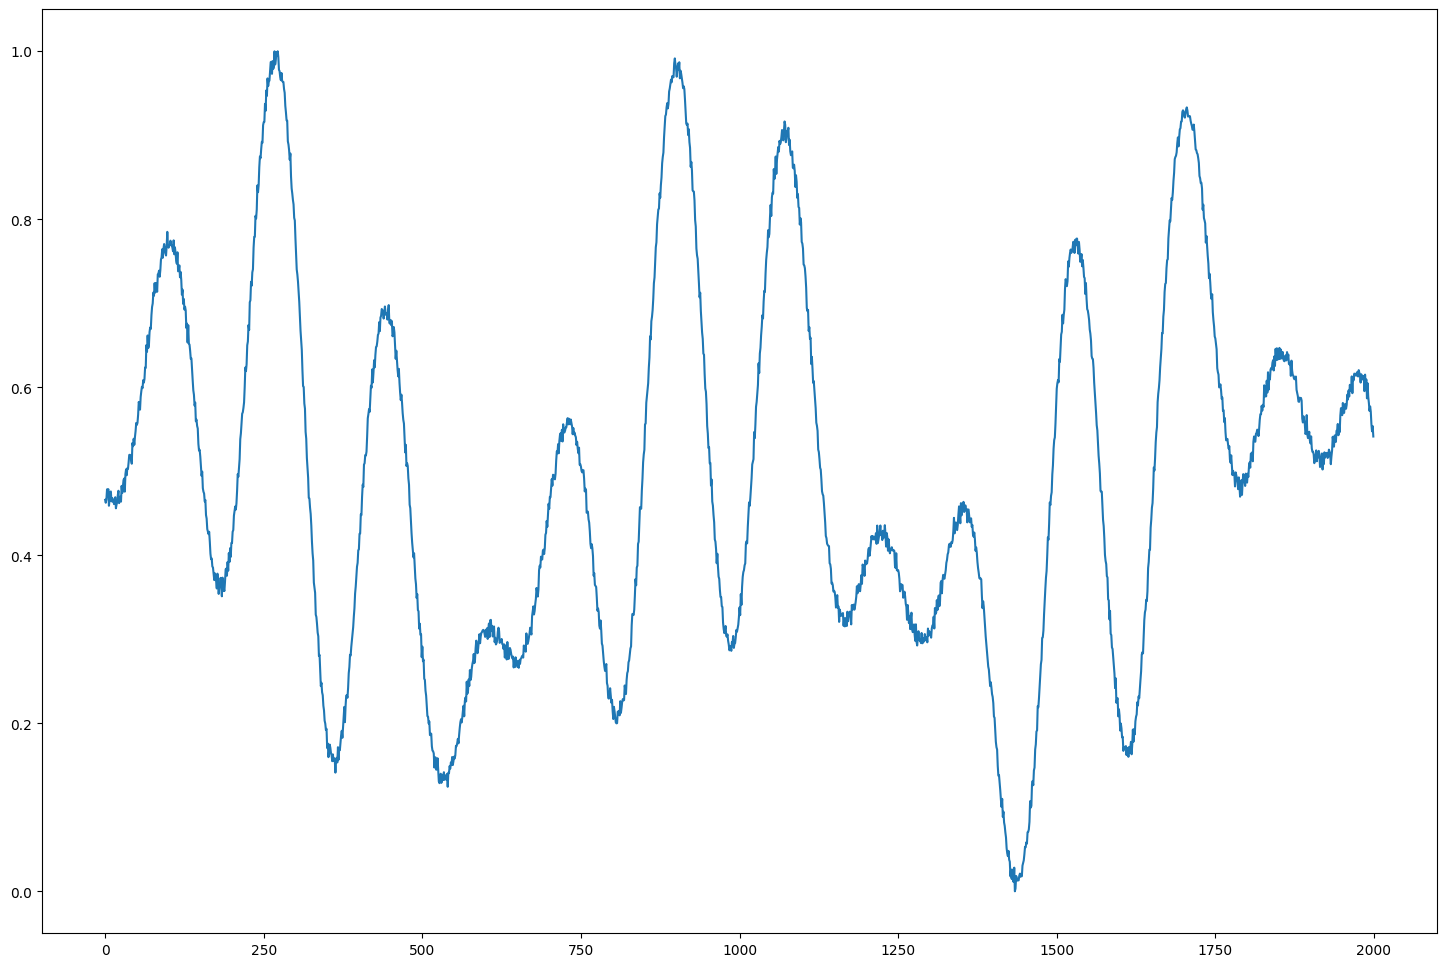

In [5]:
# rappresentazione grafica della distribuzione creata
plt.figure(figsize=(18,12))
plt.plot(df)
plt.show() 

In [8]:
# conversione in array numpy
values = df.values

In [9]:
# costruzione delle sequenze temporali
step = 100

def convert_to_matrix(data, step):
    """
        metodo per convertire un array [x1, x2, ..., xn] in una matrice
        del tipo [ [ x1, x2, ..., xstep    ],
                   [ x2, x3, ..., xstep + 1],
                   [ ...                   ],
                   [ ...xstep n-1, xstep n ] ]
    """
    x, y = [], []
    for i in range(len(data) - step):
        d = i + step  
        x.append(data[i:d,])
        y.append(data[d,])
    return np.array(x), np.array(y)

train_x, train_y = convert_to_matrix(values[:test_split_point], step)
test_x, test_y = convert_to_matrix(values[test_split_point:], step)

In [10]:
print('Shape addestramento   x', train_x.shape, '   y', train_y.shape)
print('Shape test            x', test_x.shape, '    y', test_y.shape)

Shape addestramento   x (1500, 100, 1)    y (1500, 1)
Shape test            x (300, 100, 1)     y (300, 1)


In [25]:
print(f"{train_x[0][1]} -- sucessivo {train_x[0][2]}")
print(f"{train_y[1]}")



[0.45480751] -- sucessivo [0.45927027]
[0.77950058]


In [11]:
# costruzione del modello
model = Sequential()
model.add(SimpleRNN(units=64, input_shape=(step, 1), return_sequences=True))
model.add(SimpleRNN(units=64, return_sequences=True))
model.add(SimpleRNN(units=64))
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=Nadam(), metrics=['mean_absolute_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100, 64)           4224      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100, 64)           8256      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 23905 (93.38 KB)
Trainable params: 23905 (

In [12]:
# addestramento del modello
start = timer()
rnn_h = model.fit(train_x, train_y, epochs=10, batch_size=512, verbose=2)
end = timer()
rnn_t = end - start
print(f"terminato in {rnn_t} secondi")

Epoch 1/10
3/3 - 6s - loss: 0.1998 - mean_absolute_error: 0.3653 - 6s/epoch - 2s/step
Epoch 2/10
3/3 - 1s - loss: 0.0147 - mean_absolute_error: 0.0924 - 804ms/epoch - 268ms/step
Epoch 3/10
3/3 - 1s - loss: 0.0050 - mean_absolute_error: 0.0577 - 762ms/epoch - 254ms/step
Epoch 4/10
3/3 - 1s - loss: 0.0034 - mean_absolute_error: 0.0480 - 774ms/epoch - 258ms/step
Epoch 5/10
3/3 - 1s - loss: 0.0028 - mean_absolute_error: 0.0431 - 848ms/epoch - 283ms/step
Epoch 6/10
3/3 - 1s - loss: 0.0030 - mean_absolute_error: 0.0451 - 842ms/epoch - 281ms/step
Epoch 7/10
3/3 - 1s - loss: 0.0081 - mean_absolute_error: 0.0799 - 883ms/epoch - 294ms/step
Epoch 8/10
3/3 - 1s - loss: 0.0052 - mean_absolute_error: 0.0619 - 1s/epoch - 347ms/step
Epoch 9/10
3/3 - 1s - loss: 0.0016 - mean_absolute_error: 0.0313 - 973ms/epoch - 324ms/step
Epoch 10/10
3/3 - 1s - loss: 0.0012 - mean_absolute_error: 0.0275 - 868ms/epoch - 289ms/step
terminato in 13.630990086006932


In [26]:
# predizioni (come si comporta il modello su tutto il dataset,
# considerando separatamente i dati di train e di test)
train_predict_rnn = model.predict(train_x)
test_predict_rnn = model.predict(test_x)

10/10 [==============================] - 0s 20ms/step


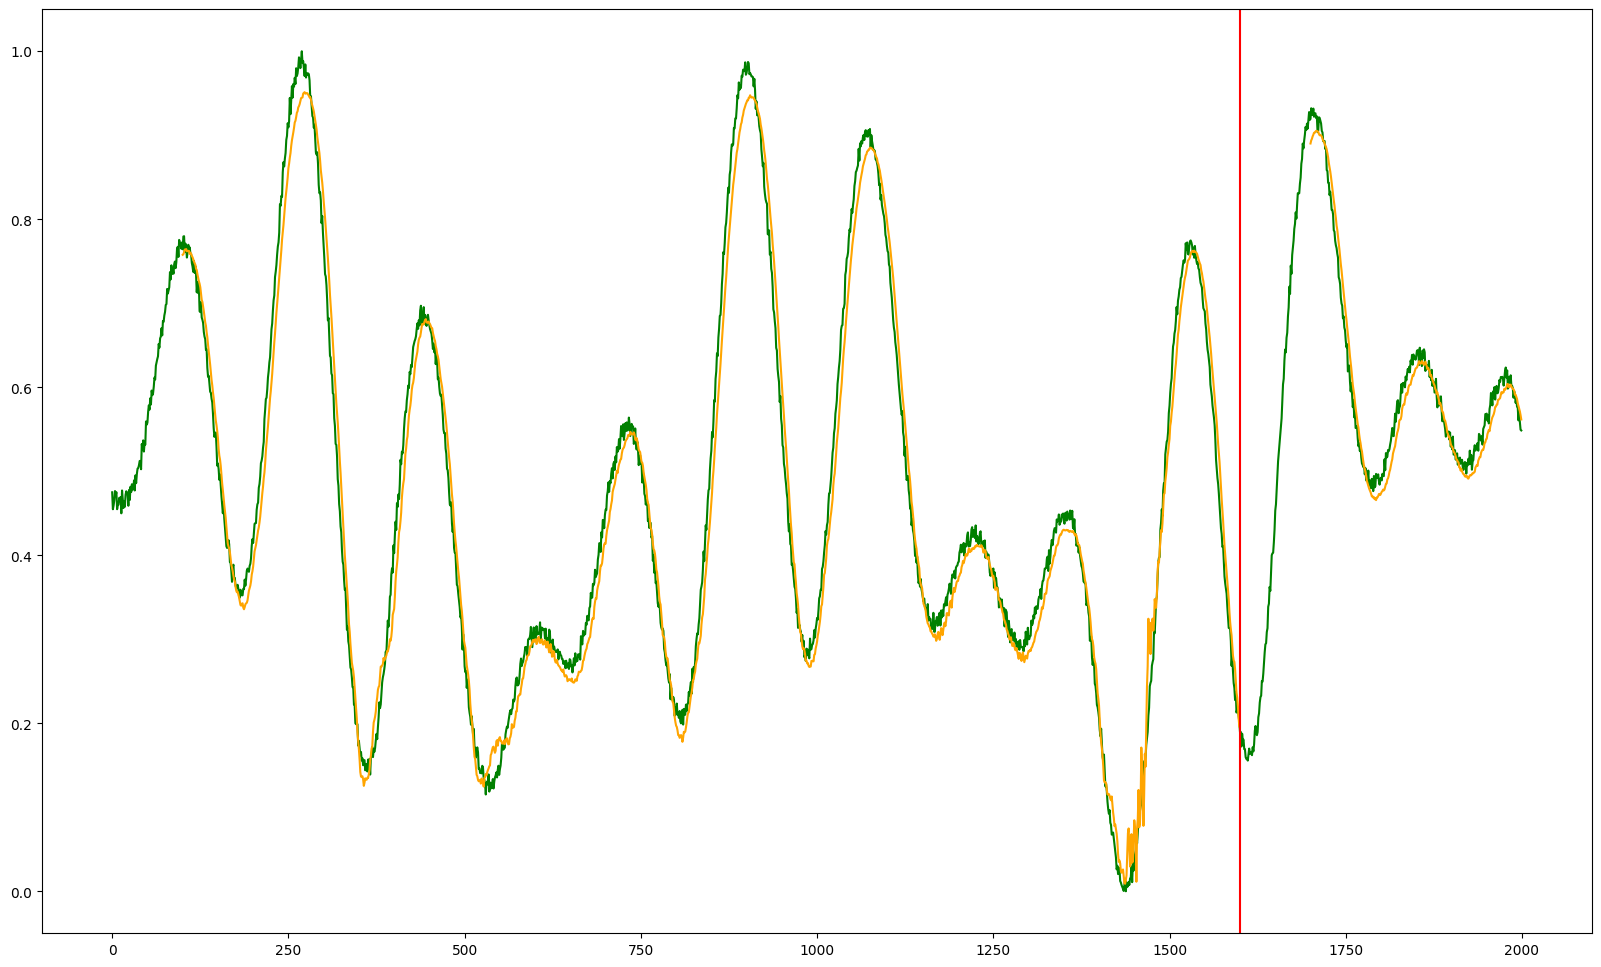

In [27]:
# grafico relativo all'output del modello rispetto
# ai dati reali iniziali
index = df.index.values
plt.figure(figsize=(20,12))
plt.plot(df, color='green')

x_train_preds = [x for x in range(step, len(train_predict_rnn) + step)]
plt.plot(x_train_preds, train_predict_rnn, color='orange')

x_test_preds = [test_split_point + x + step for x in range(0, len(test_predict_rnn))]
plt.plot(x_test_preds, test_predict_rnn, color='orange')

plt.axvline(df.index[test_split_point], c='r')
plt.show() 

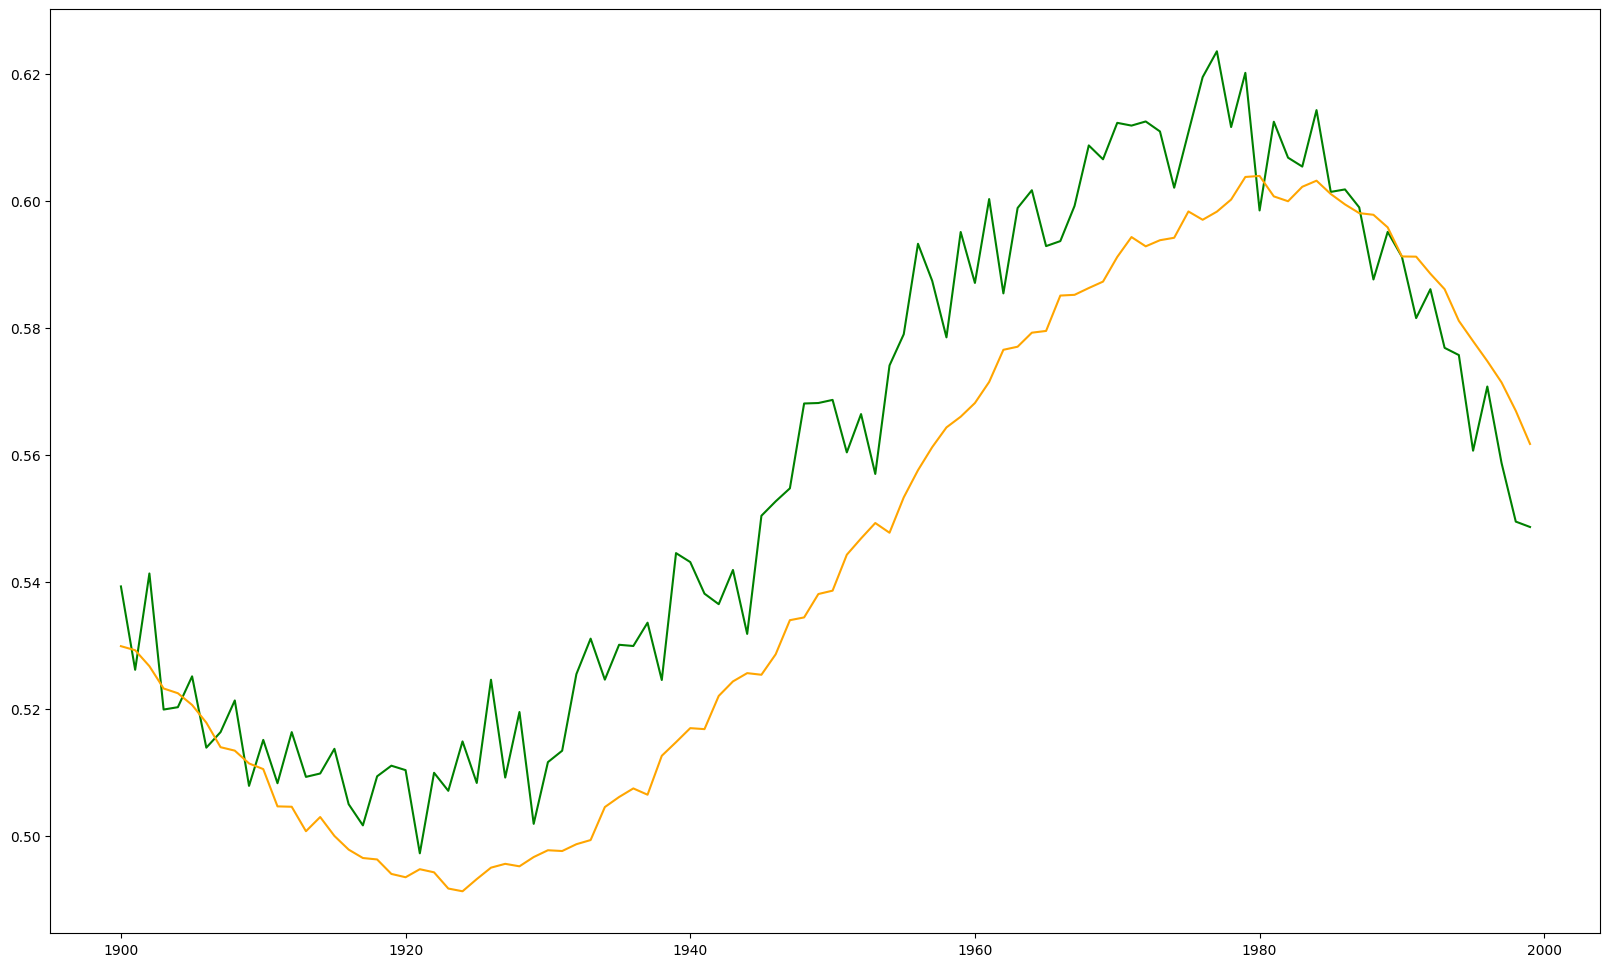

In [28]:
# grafico relativo all'output del modello rispetto
# ai dati reali iniziali - osservazione degli ultimi 100 esempi
plt.figure(figsize=(20,12))
plt.plot(df[-100:], color='green')
plt.plot(x_test_preds[-100:], test_predict_rnn[-100:], color='orange')
plt.show()

In [29]:
# costruzione del modello tramite celle LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units=64, input_shape=(step, 1), return_sequences=True))
model_lstm.add(LSTM(units=64, return_sequences=True))
model_lstm.add(LSTM(units=64,))
model_lstm.add(Dense(32, activation="relu"))
model_lstm.add(Dense(32, activation="relu"))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer=Nadam(), metrics=['mean_absolute_error'])
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 64)           16896     
                                                                 
 lstm_1 (LSTM)               (None, 100, 64)           33024     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 86113 (336.38 KB)
Trainable params: 8611

In [30]:
# addestramento del modello basato su celle LSTM
start = timer()
lstm_h = model_lstm.fit(train_x, train_y, epochs=10, batch_size=512, verbose=2)
end = timer()
lstm_t = end - start
print(f"terminato in {lstm_t} secondi")

Epoch 1/10
3/3 - 12s - loss: 0.2402 - mean_absolute_error: 0.4352 - 12s/epoch - 4s/step
Epoch 2/10
3/3 - 4s - loss: 0.1422 - mean_absolute_error: 0.3221 - 4s/epoch - 1s/step
Epoch 3/10
3/3 - 4s - loss: 0.0260 - mean_absolute_error: 0.1263 - 4s/epoch - 1s/step
Epoch 4/10
3/3 - 4s - loss: 0.0173 - mean_absolute_error: 0.1088 - 4s/epoch - 1s/step
Epoch 5/10
3/3 - 4s - loss: 0.0147 - mean_absolute_error: 0.0990 - 4s/epoch - 1s/step
Epoch 6/10
3/3 - 4s - loss: 0.0120 - mean_absolute_error: 0.0911 - 4s/epoch - 1s/step
Epoch 7/10
3/3 - 4s - loss: 0.0108 - mean_absolute_error: 0.0844 - 4s/epoch - 1s/step
Epoch 8/10
3/3 - 4s - loss: 0.0091 - mean_absolute_error: 0.0780 - 4s/epoch - 1s/step
Epoch 9/10
3/3 - 4s - loss: 0.0065 - mean_absolute_error: 0.0659 - 4s/epoch - 1s/step
Epoch 10/10
3/3 - 4s - loss: 0.0054 - mean_absolute_error: 0.0602 - 4s/epoch - 1s/step
terminato in 47.1166371400177 secondi


In [31]:
# analisi del comportamento del modello
train_predict_lstm = model_lstm.predict(train_x)
test_predict_lstm = model_lstm.predict(test_x)

10/10 [==============================] - 2s 188ms/step


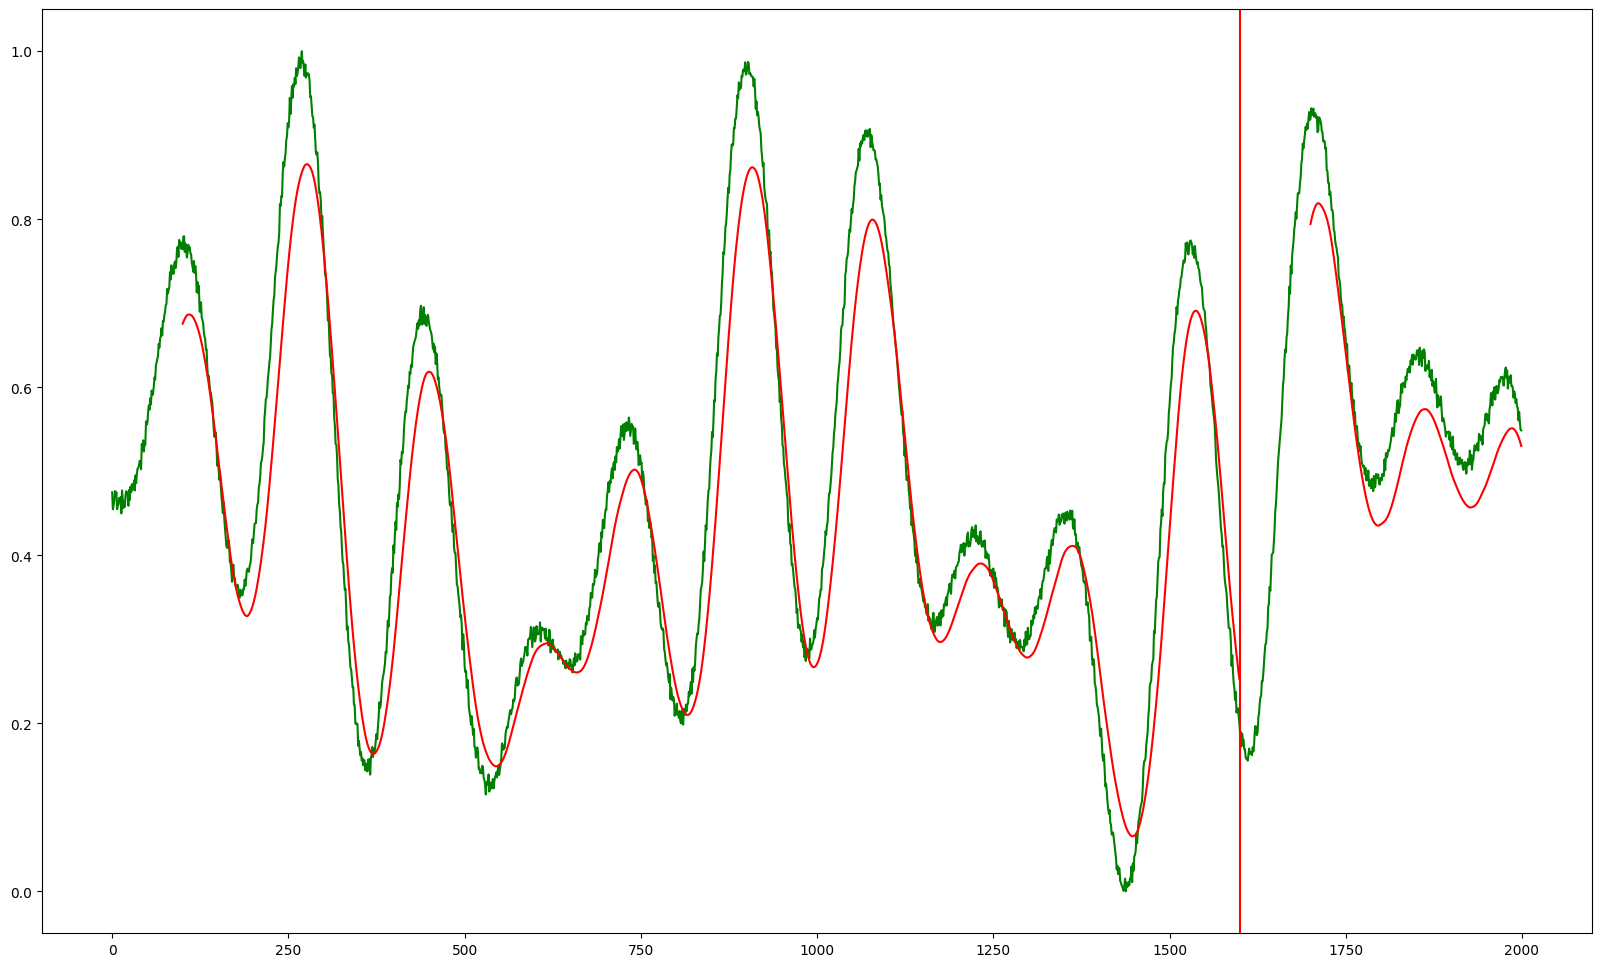

In [32]:
# confronto del comportamento del modello
# rispetto ai dati reali
index = df.index.values
plt.figure(figsize=(20,12))
plt.plot(df, color='green')

x_train_preds = [x for x in range(step, len(train_predict_lstm) + step)]
plt.plot(x_train_preds, train_predict_lstm, color='red')

x_test_preds = [test_split_point + x + step for x in range(0, len(test_predict_lstm))]
plt.plot(x_test_preds, test_predict_lstm, color='red')

plt.axvline(df.index[test_split_point], c='r')
plt.show()

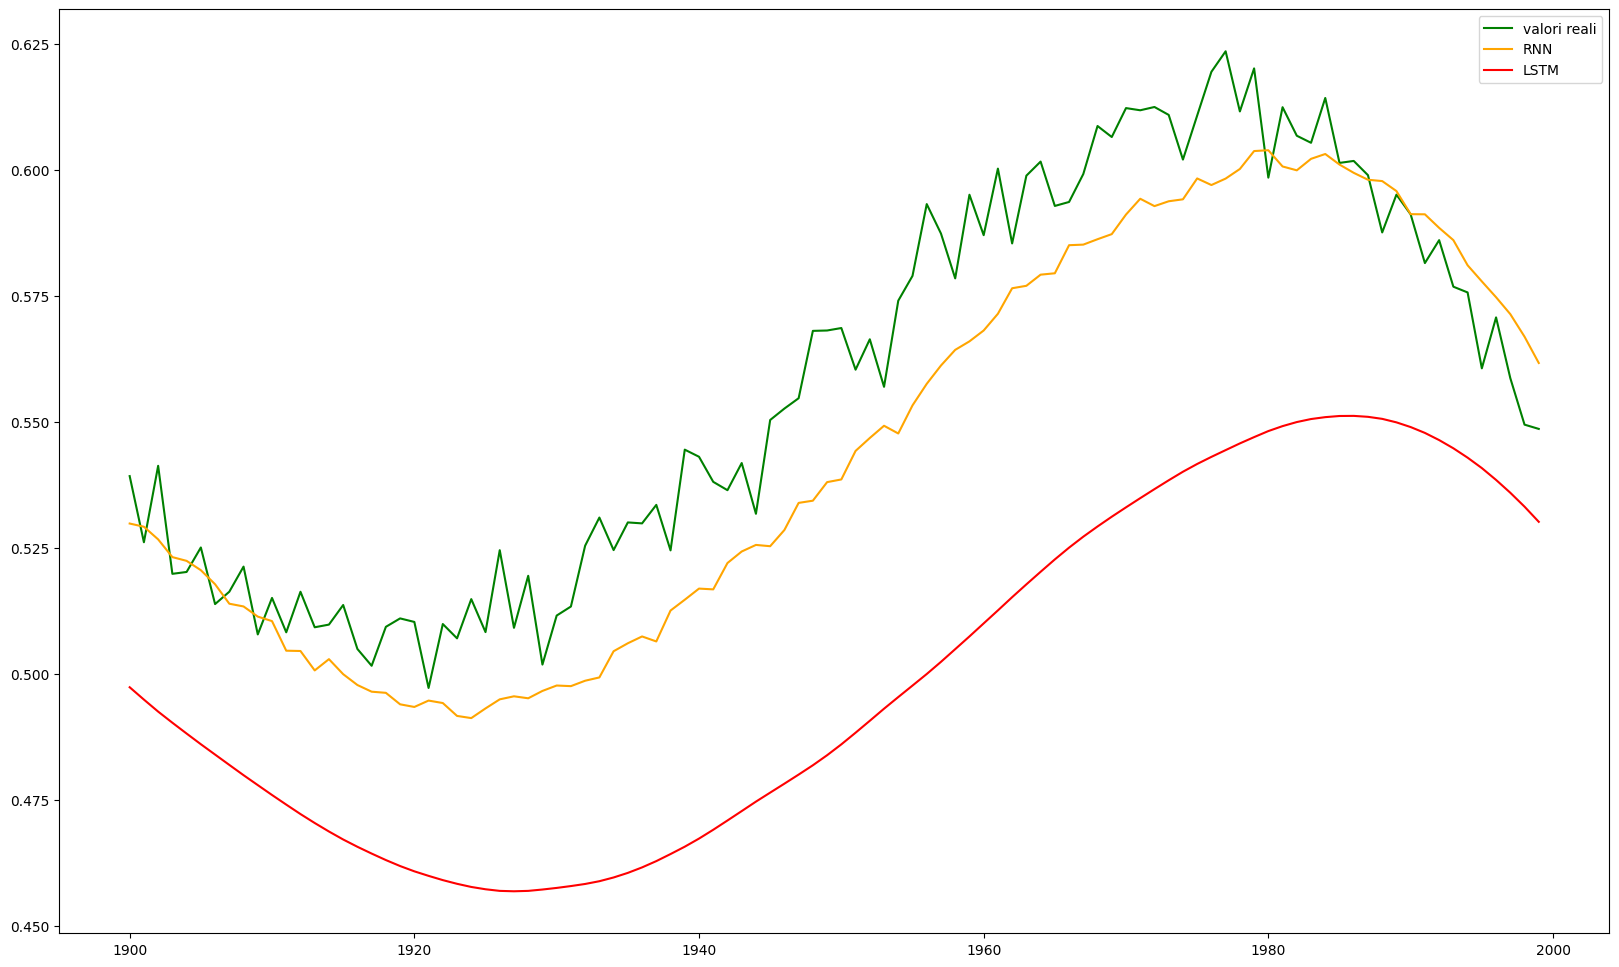

In [33]:
# analisi sugli ultimi 100 esempi predetti rispetto
# ai dati reali iniziali
plt.figure(figsize=(20,12))
plt.plot(df[-100:], color='green', label='valori reali')
plt.plot(x_test_preds[-100:], test_predict_rnn[-100:], color='orange', label='RNN')
plt.plot(x_test_preds[-100:], test_predict_lstm[-100:], color='red', label='LSTM')
plt.legend()
plt.show()

In [34]:
# costruzione di un modello basato su celle di tipo GRU
model_gru = Sequential()
model_gru.add(GRU(units=64, input_shape=(step, 1), return_sequences=True))
model_gru.add(GRU(units=64, return_sequences=True))
model_gru.add(GRU(units=64))
model_gru.add(Dense(32, activation="relu"))
model_gru.add(Dense(32, activation="relu"))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer=Nadam(), metrics=['mean_absolute_error'])
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100, 64)           12864     
                                                                 
 gru_1 (GRU)                 (None, 100, 64)           24960     
                                                                 
 gru_2 (GRU)                 (None, 64)                24960     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 65953 (257.63 KB)
Trainable params: 6595

In [35]:
# addestramento del modello basato su celle GRU
start = timer()
gru_h = model_gru.fit(train_x, train_y, epochs=10, batch_size=512, verbose=2)
end = timer()
gru_t = end - start
print(f"terminato in {gru_t} secondi")

Epoch 1/10
3/3 - 11s - loss: 0.2506 - mean_absolute_error: 0.4459 - 11s/epoch - 4s/step
Epoch 2/10
3/3 - 3s - loss: 0.1831 - mean_absolute_error: 0.3762 - 3s/epoch - 1s/step
Epoch 3/10
3/3 - 3s - loss: 0.0913 - mean_absolute_error: 0.2502 - 3s/epoch - 975ms/step
Epoch 4/10
3/3 - 3s - loss: 0.0160 - mean_absolute_error: 0.0975 - 3s/epoch - 1s/step
Epoch 5/10
3/3 - 3s - loss: 0.0116 - mean_absolute_error: 0.0942 - 3s/epoch - 1s/step
Epoch 6/10
3/3 - 3s - loss: 0.0086 - mean_absolute_error: 0.0815 - 3s/epoch - 1s/step
Epoch 7/10
3/3 - 3s - loss: 0.0069 - mean_absolute_error: 0.0723 - 3s/epoch - 1s/step
Epoch 8/10
3/3 - 3s - loss: 0.0058 - mean_absolute_error: 0.0657 - 3s/epoch - 861ms/step
Epoch 9/10
3/3 - 3s - loss: 0.0049 - mean_absolute_error: 0.0598 - 3s/epoch - 1s/step
Epoch 10/10
3/3 - 3s - loss: 0.0040 - mean_absolute_error: 0.0537 - 3s/epoch - 1s/step
terminato in 38.779236047004815 secondi


In [36]:
# analisi dell'output del modello
train_predict_gru = model_gru.predict(train_x)
test_predict_gru = model_gru.predict(test_x)

10/10 [==============================] - 0s 30ms/step


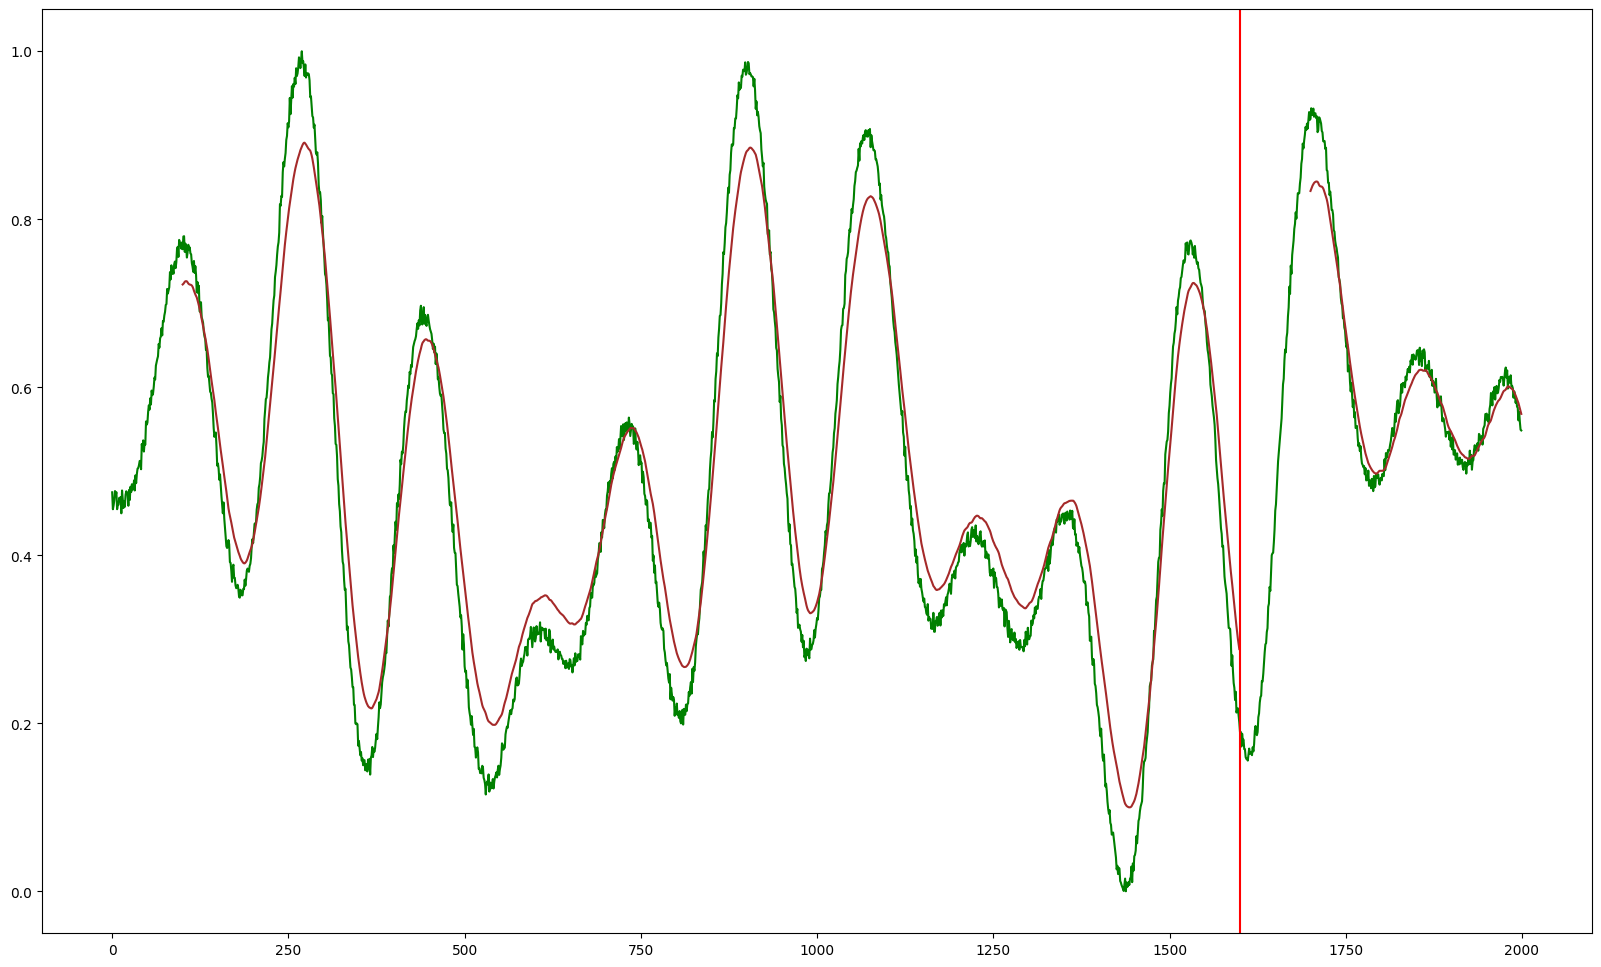

In [37]:
# grafico di confronto dell'output del modello
# rispetto ai dati iniziali
index = df.index.values
plt.figure(figsize=(20,12))
plt.plot(df, color='green')

x_train_preds = [x for x in range(step, len(train_predict_gru) + step)]
plt.plot(x_train_preds, train_predict_gru, color='brown')

x_test_preds = [test_split_point + x + step for x in range(0, len(test_predict_gru))]
plt.plot(x_test_preds, test_predict_gru, color='brown')

plt.axvline(df.index[test_split_point], c='r')
plt.show()

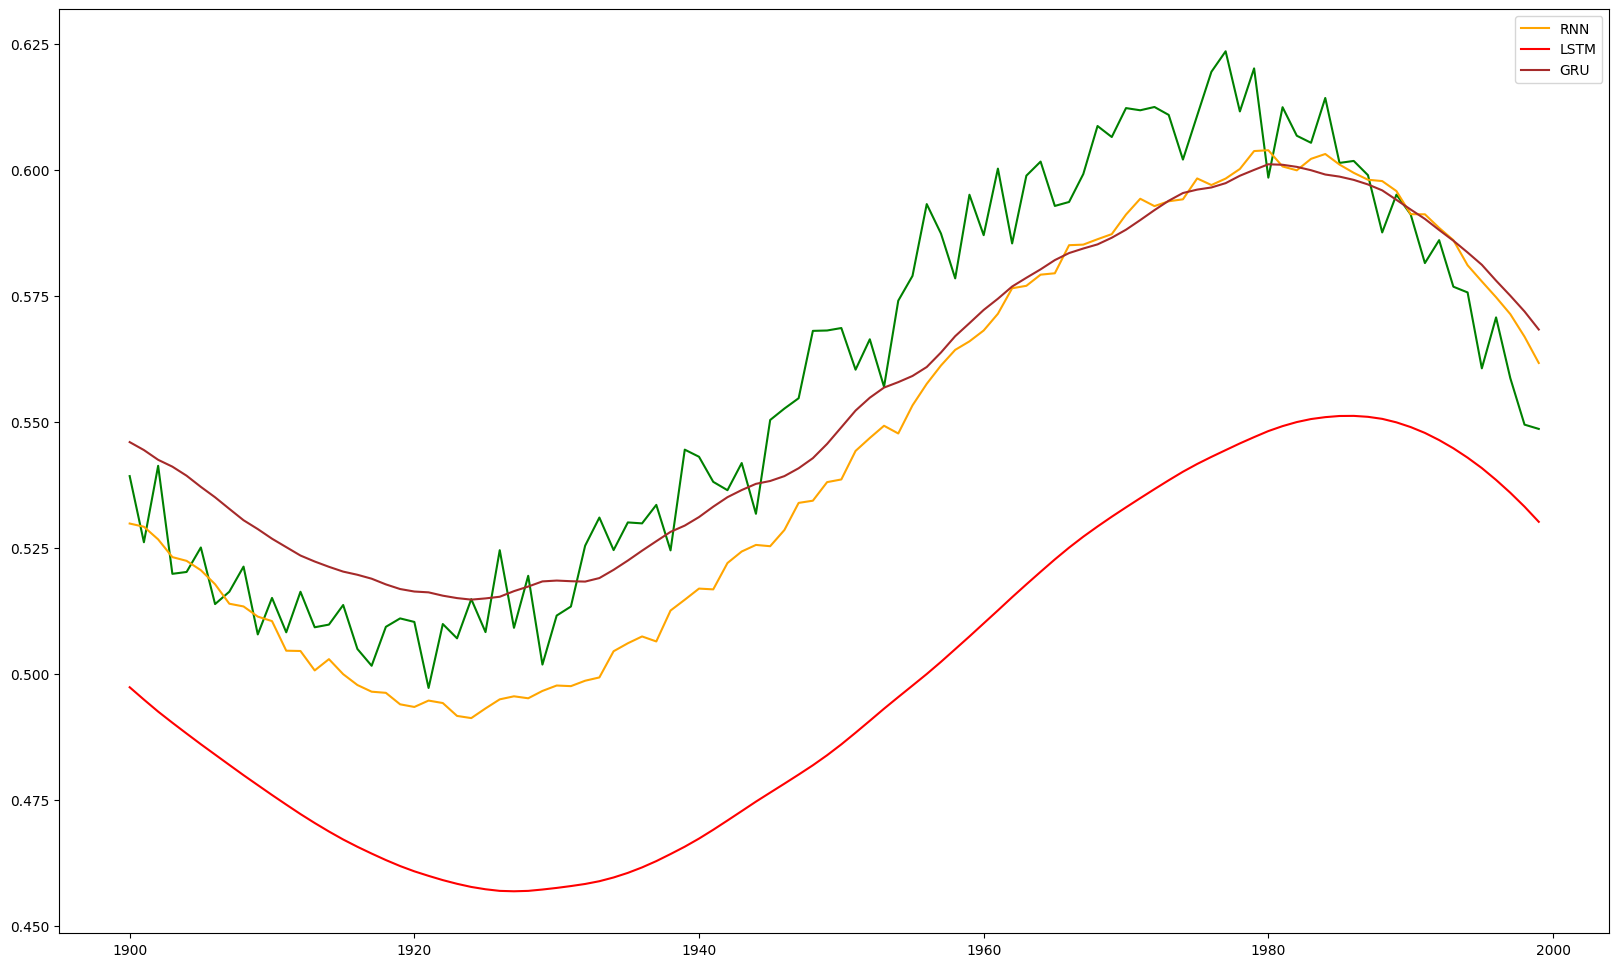

In [38]:
# grafico di dettaglio degli ultimi 100 esempi
# generati dal modello attuale rispetto ai precedenti
plt.figure(figsize=(20,12))
plt.plot(df[-100:], color='green')
plt.plot(x_test_preds[-100:], test_predict_rnn[-100:], color='orange', label='RNN')
plt.plot(x_test_preds[-100:], test_predict_lstm[-100:], color='red', label='LSTM')
plt.plot(x_test_preds[-100:], test_predict_gru[-100:], color='brown', label='GRU')
plt.legend()
plt.show()

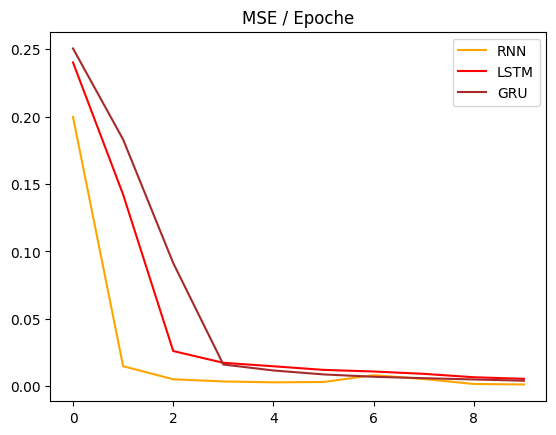

<Figure size 2000x1200 with 0 Axes>

In [39]:
# grafico del Loss dei 3 modelli implementati
f, ax = plt.subplots()
plt.figure(figsize=(20,12))
ax.set_title('MSE / Epoche')
ax.plot(rnn_h.history['loss'], color='orange')
ax.plot(lstm_h.history['loss'], color='red')
ax.plot(gru_h.history['loss'], color='brown')
ax.legend(['RNN', 'LSTM', 'GRU'], loc = 0)
plt.show() 

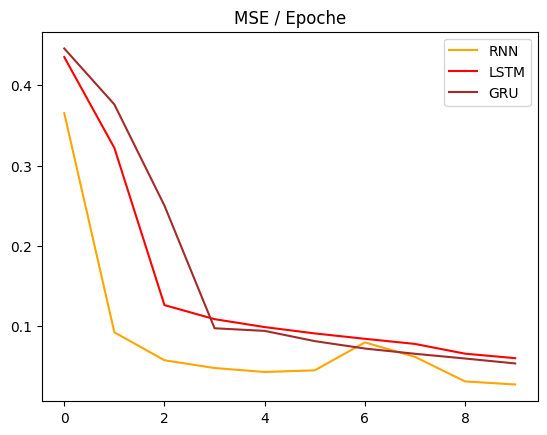

<Figure size 2000x1200 with 0 Axes>

In [40]:
# grafico dell'accuratezza
f, ax = plt.subplots()
plt.figure(figsize=(20,12))
ax.set_title('MSE / Epoche')
ax.plot(rnn_h.history['mean_absolute_error'], color='orange')
ax.plot(lstm_h.history['mean_absolute_error'], color='red')
ax.plot(gru_h.history['mean_absolute_error'], color='brown')
ax.legend(['RNN', 'LSTM', 'GRU'], loc = 0)
plt.show() 

In [41]:
# implementazione di un modello di base di rete ricorrente
model_vanilla = Sequential()
model_vanilla.add(SimpleRNN(units=64, input_shape=(step, 1), activation="relu"))
model_vanilla.add(Dense(32, activation="relu"))
model_vanilla.add(Dense(1))
model_vanilla.compile(loss='mean_squared_error', optimizer=Nadam(), metrics=['mean_absolute_error'])
model_vanilla.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 64)                4224      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 6337 (24.75 KB)
Trainable params: 6337 (24.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
# addestramento della vanilla RNN
start = timer()
vanilla_h = model_vanilla.fit(train_x, train_y, epochs=10, batch_size=512, verbose=2)
end = timer()
vanilla_t = end - start
print(f"terminato in {vanilla_t} secondi")

Epoch 1/10
3/3 - 3s - loss: 0.1814 - mean_absolute_error: 0.3794 - 3s/epoch - 840ms/step
Epoch 2/10
3/3 - 0s - loss: 0.1326 - mean_absolute_error: 0.3213 - 358ms/epoch - 119ms/step
Epoch 3/10
3/3 - 0s - loss: 0.0740 - mean_absolute_error: 0.2344 - 358ms/epoch - 119ms/step
Epoch 4/10
3/3 - 0s - loss: 0.0237 - mean_absolute_error: 0.1207 - 349ms/epoch - 116ms/step
Epoch 5/10
3/3 - 0s - loss: 0.0018 - mean_absolute_error: 0.0336 - 332ms/epoch - 111ms/step
Epoch 6/10
3/3 - 0s - loss: 0.0014 - mean_absolute_error: 0.0313 - 385ms/epoch - 128ms/step
Epoch 7/10
3/3 - 0s - loss: 6.3903e-04 - mean_absolute_error: 0.0196 - 366ms/epoch - 122ms/step
Epoch 8/10
3/3 - 0s - loss: 5.4798e-04 - mean_absolute_error: 0.0187 - 393ms/epoch - 131ms/step
Epoch 9/10
3/3 - 0s - loss: 2.7001e-04 - mean_absolute_error: 0.0132 - 380ms/epoch - 127ms/step
Epoch 10/10
3/3 - 0s - loss: 1.6348e-04 - mean_absolute_error: 0.0103 - 358ms/epoch - 119ms/step
terminato in 5.976399535982637 secondi


In [43]:
# validazione della vanilla RNN
train_predict_vanilla = model_vanilla.predict(train_x)
test_predict_vanilla = model_vanilla.predict(test_x)

10/10 [==============================] - 0s 6ms/step


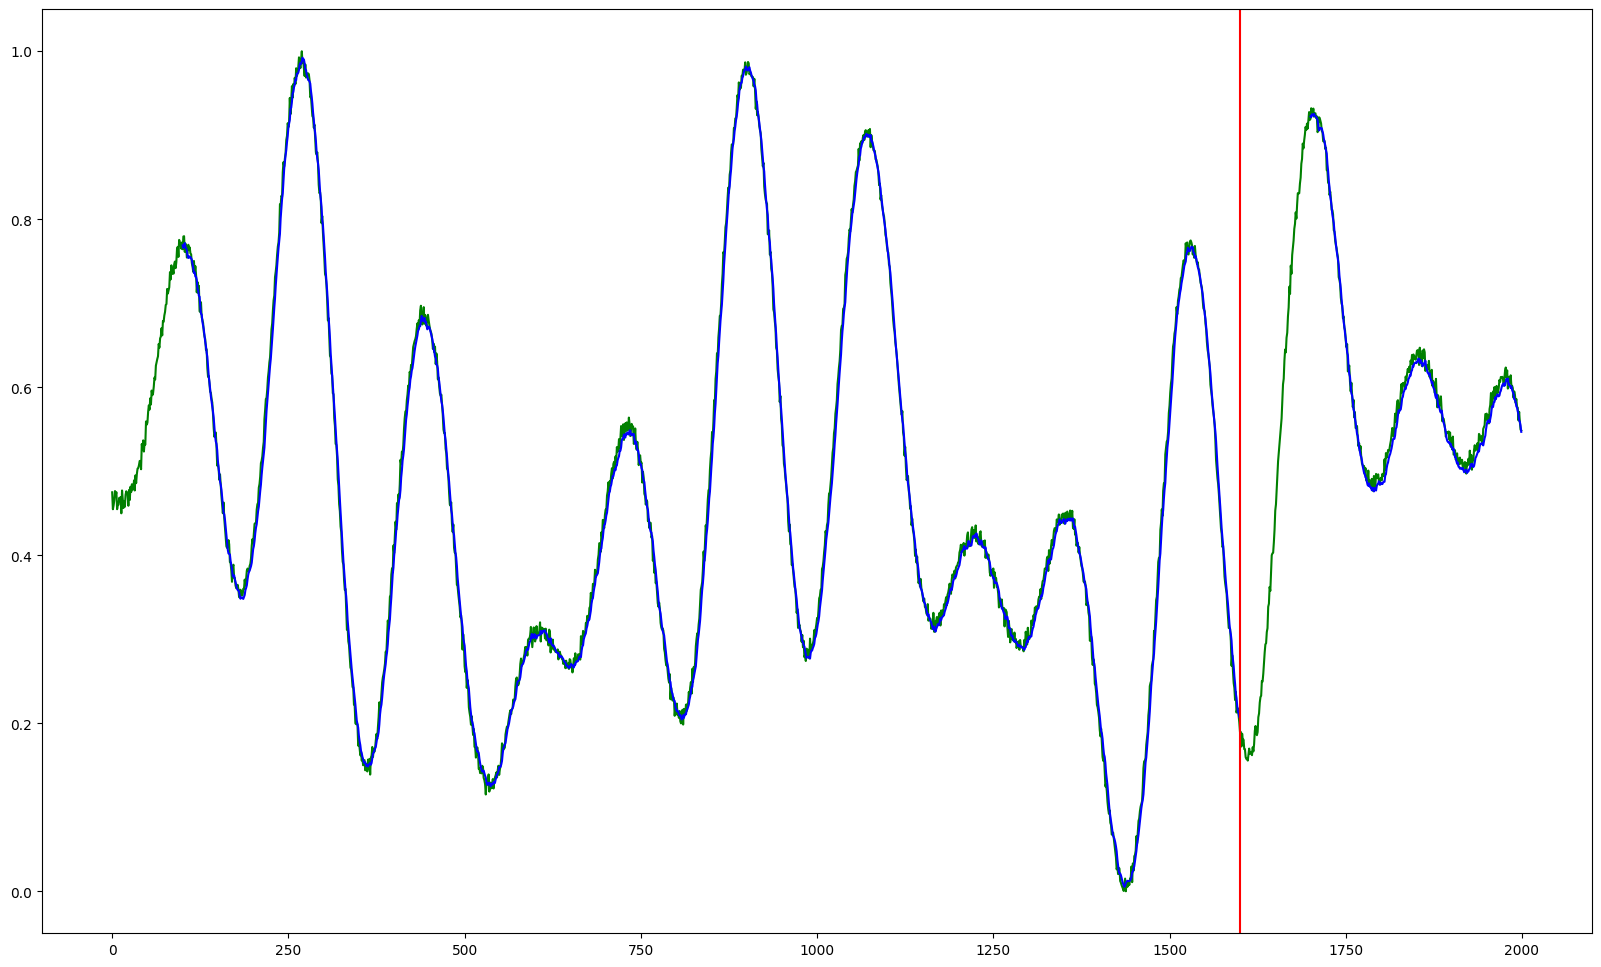

In [44]:
# grafico del confronto tra valori
# predetti e valori reali
index = df.index.values
plt.figure(figsize=(20,12))
plt.plot(df, color='green')

x_train_preds = [x for x in range(step, len(train_predict_vanilla) + step)]
plt.plot(x_train_preds, train_predict_vanilla, color='blue')

x_test_preds = [test_split_point + x + step for x in range(0, len(test_predict_vanilla))]
plt.plot(x_test_preds, test_predict_vanilla, color='blue')

plt.axvline(df.index[test_split_point], c='r')
plt.show()

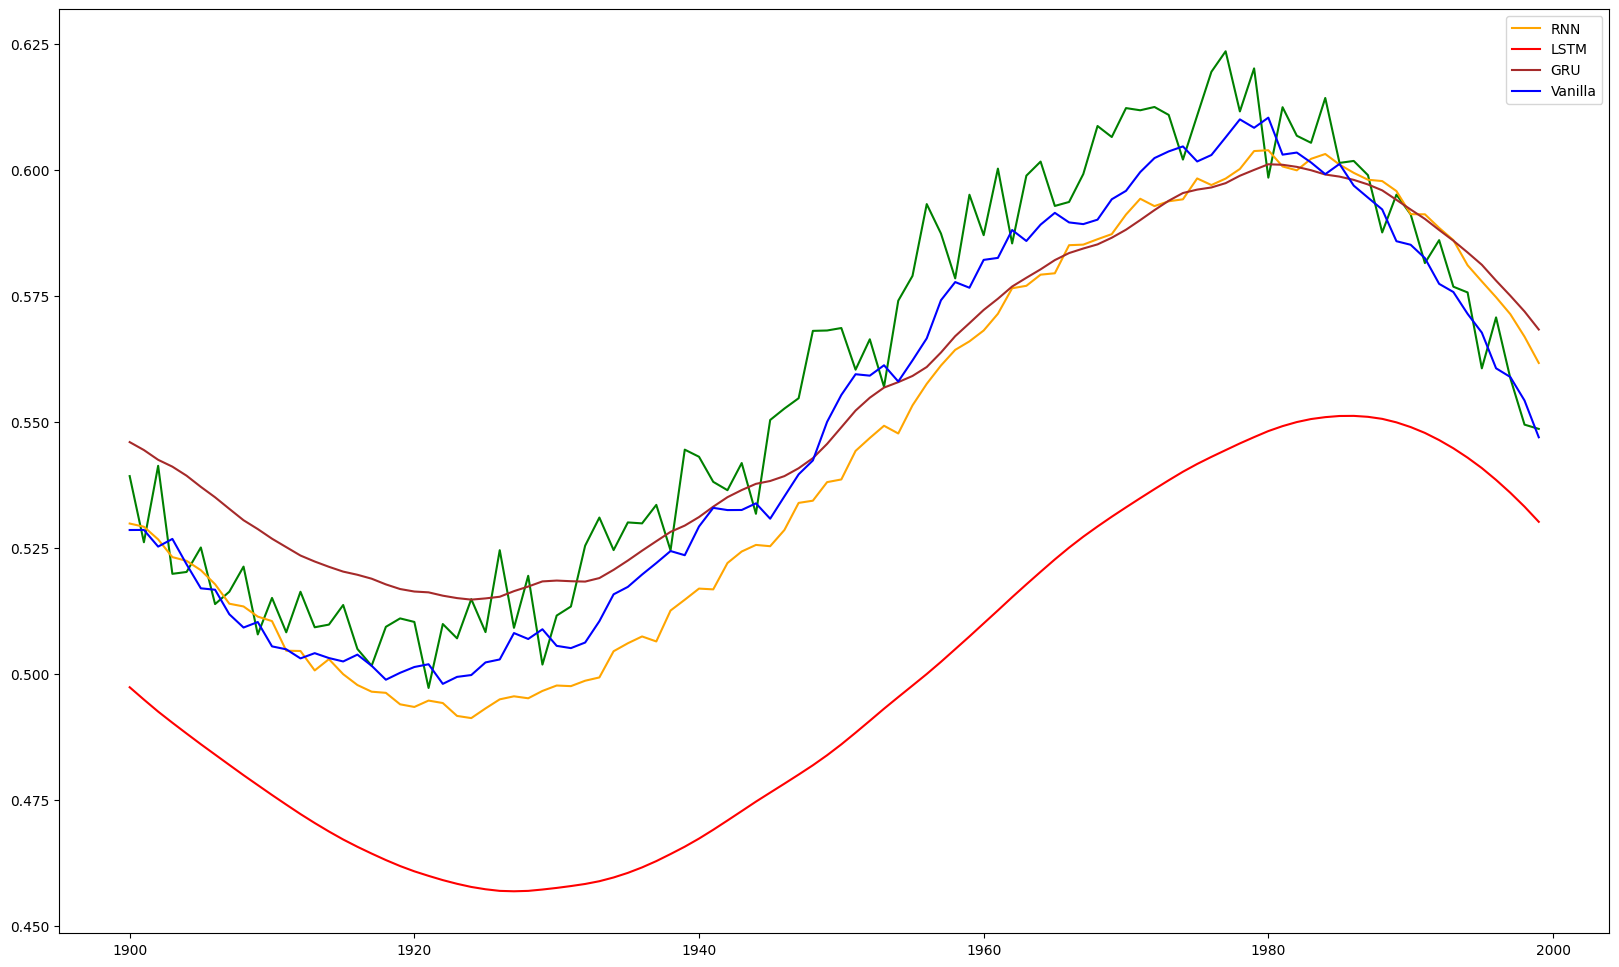

In [45]:
# confronto tra tutti i modelli creati e i dati reali
# per gli ultimi 100 esempi
plt.figure(figsize=(20,12))
plt.plot(df[-100:], color='green')
plt.plot(x_test_preds[-100:], test_predict_rnn[-100:], color='orange', label='RNN')
plt.plot(x_test_preds[-100:], test_predict_lstm[-100:], color='red', label='LSTM')
plt.plot(x_test_preds[-100:], test_predict_gru[-100:], color='brown', label='GRU')
plt.plot(x_test_preds[-100:], test_predict_vanilla[-100:], color='blue', label='Vanilla')
plt.legend()
plt.show()

<Figure size 2000x1200 with 0 Axes>

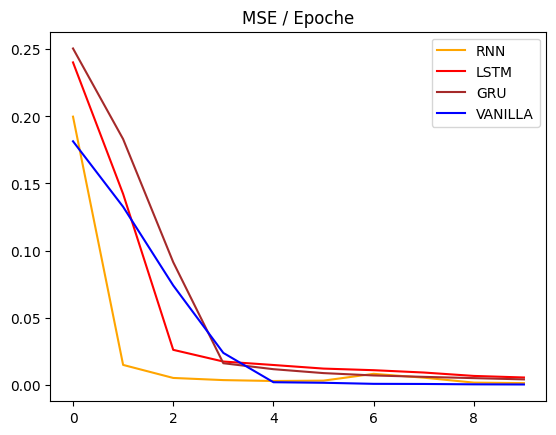

In [46]:
# andamento del loss nei vari modelli
plt.figure(figsize=(20,12))
f, ax = plt.subplots()
ax.set_title('MSE / Epoche')
ax.plot(rnn_h.history['loss'], color='orange')
ax.plot(lstm_h.history['loss'], color='red')
ax.plot(gru_h.history['loss'], color='brown')
ax.plot(vanilla_h.history['loss'], color='blue')
ax.legend(['RNN', 'LSTM', 'GRU', 'VANILLA'], loc = 0)
plt.show() 

<Figure size 2000x1200 with 0 Axes>

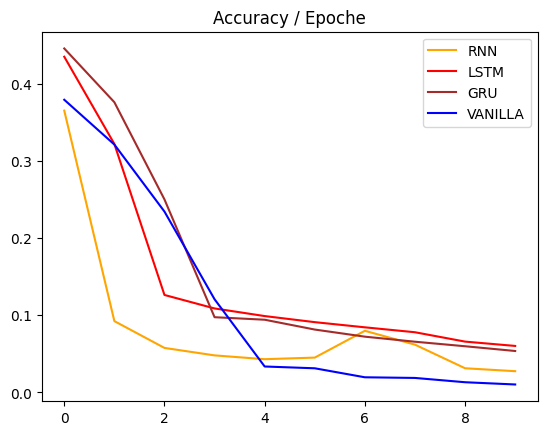

In [47]:
# andamento dell'accuracy tra i vari modelli
plt.figure(figsize=(20,12))
f, ax = plt.subplots()
ax.set_title('Accuracy / Epoche')
ax.plot(rnn_h.history['mean_absolute_error'], color='orange')
ax.plot(lstm_h.history['mean_absolute_error'], color='red')
ax.plot(gru_h.history['mean_absolute_error'], color='brown')
ax.plot(vanilla_h.history['mean_absolute_error'], color='blue')
ax.legend(['RNN', 'LSTM', 'GRU', 'VANILLA'], loc = 0)
plt.show() 

In [48]:
print('          loss      mae     time')
print('LSTM    ', str(lstm_h.history['loss'][len(lstm_h.history['loss'])-1])[:5], '  ', str(lstm_h.history['mean_absolute_error'][len(lstm_h.history['mean_absolute_error'])-1])[:5],
      '   ' + str(lstm_t)[:5])
print('GRU     ', str(gru_h.history['loss'][len(gru_h.history['loss'])-1])[:5], '  ', str(gru_h.history['mean_absolute_error'][len(gru_h.history['mean_absolute_error'])-1])[:5],
      '   ' + str(gru_t)[:5])
print('RNN     ', str(rnn_h.history['loss'][len(rnn_h.history['loss'])-1])[:5], '  ', str(rnn_h.history['mean_absolute_error'][len(rnn_h.history['mean_absolute_error'])-1])[:5],
      '    ' + str(rnn_t)[:4])
print('VANILLA ', str(vanilla_h.history['loss'][len(vanilla_h.history['loss'])-1])[:5], '  ', 
      str(vanilla_h.history['mean_absolute_error'][len(vanilla_h.history['mean_absolute_error'])-1])[:5], '    ' + str(vanilla_t)[:4])

          loss      mae     time
LSTM     0.005    0.060    47.11
GRU      0.003    0.053    38.77
RNN      0.001    0.027     13.6
VANILLA  0.000    0.010     5.97
